        ┌───┐ ░ ┌─┐
     q: ┤ H ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0 
Counts: {'1': 494, '0': 506}


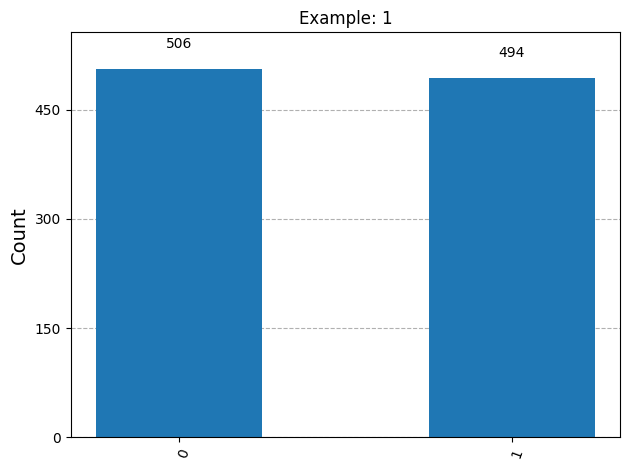

In [84]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from math import sin, asin, floor, sqrt, pi
from qiskit.quantum_info import Statevector
import numpy as np

def Z_f(target_strings: list[str], n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n, name="Z_f")
    for s in target_strings:
        if len(s) != n or set(s) - {"0","1"}:
            raise ValueError(f"Invalid bitstring: {s}")

        # Mask zeros so |s> -> |11..1>
        for i, bit in enumerate(reversed(s)):
            if bit == '0':
                qc.x(i)

        if n == 1:
            qc.z(0)                # no H wrappers
        elif n == 2:
            qc.cz(0, 1)            # no H wrappers
        else:
            qc.h(n-1)              # H–MCX–H only for n>=3
            qc.mcx(list(range(n-1)), n-1)
            qc.h(n-1)

        # Unmask
        for i, bit in enumerate(reversed(s)):
            if bit == '0':
                qc.x(i)
    return qc


def Z_or(n: int) -> QuantumCircuit:
    """
    Implements (up to a global phase) the reflection about |0...0>:
        R0 = 2|0...0><0...0| - I
    i.e., phase -1 on |0...0>, +1 elsewhere.
    """
    qc = QuantumCircuit(n, name="Z_or")
    qc.x(range(n))

    if n == 1:
        qc.z(0)
    elif n == 2:
        qc.cz(0, 1)
    else:
        qc.h(n-1)
        qc.mcx(list(range(n-1)), n-1)  # controls: 0..n-2, target: n-1
        qc.h(n-1)

    qc.x(range(n))
    return qc

def grovers_operation(target_strings: list[str],n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n)
    qc.append(Z_f(target_strings, n), range(n))
    qc.h(range(n))
    qc.append(Z_or(n), range(n))
    qc.h(range(n))
    return qc


target_strings = ["1"]

n = len(target_strings[0])
s = len(target_strings)
N = 2 ** n
theta = asin(sqrt(s/N))
r_est = floor((pi/(4*theta)) - 0.5)
P = lambda r: sin((2*r+1)*theta)**2
num_iterations = max(0, max([r_est, r_est+1], key=P))

qc0 = grovers_operation(target_strings, n).to_instruction()
qc = QuantumCircuit(n)
qc.h(range(n))
for i in range(num_iterations):
    qc.append(qc0, range(n))
qc.measure_all()

print(qc.draw("text"))


# Run on simulator
sim = Aer.get_backend("aer_simulator")
tqc = transpile(qc, sim)
result = sim.run(tqc, shots = 1000).result()
counts = result.get_counts()
print("Counts:", counts)
plot_histogram(counts, title="Example: "+ ", ".join(target_strings))

In [ ]:
n=3
qc = QuantumCircuit(n)
qc.mcx(list(range(n-1)), n-1)
print(qc.draw("text"))

          
q_0: ──■──
       │  
q_1: ──■──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘
